# Telecom Customer Intelligence System
### Clustering, Classification & Regression using Machine Learning Pipelines

This project analyzes telecom customer data to perform customer segmentation,
predict customer churn, and estimate monthly charges using end-to-end
machine learning pipelines.


## Problem Statement

Telecom companies generate large volumes of customer data but often lack
integrated systems to extract actionable insights. The challenge is to
segment customers, predict churn, and estimate revenue using a unified
machine learning approach. This project solves the problem using pipeline-
based clustering, classification, and regression models.


In [1]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression

from sklearn.metrics import (
    accuracy_score,
    classification_report,
    mean_squared_error,
    r2_score,
    silhouette_score
)

import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")


In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("blastchar/telco-customer-churn")

print("Path to dataset files:", path)

Path to dataset files: C:\Users\MOHAMMED HAYATH RK\.cache\kagglehub\datasets\blastchar\telco-customer-churn\versions\1


In [3]:
import os

# List files
files = os.listdir(path)
print(files)

['WA_Fn-UseC_-Telco-Customer-Churn.csv']


In [4]:
# Use the path returned by kagglehub
base_path = path  # path from kagglehub

In [5]:
df = pd.read_csv(os.path.join(base_path, "WA_Fn-UseC_-Telco-Customer-Churn.csv"))
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


## Data Cleaning

In [6]:
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df['TotalCharges'].fillna(df['TotalCharges'].median(), inplace=True)
df.drop('customerID', axis=1, inplace=True)

# MODEL 1: CLUSTERING

## Model 1: Customer Segmentation (Clustering)
KMeans clustering is used to segment customers based on behavioral patterns.


### CLUSTERING PIPELINE

In [7]:
# Create a copy of the dataset for clustering
# (Clustering is an unsupervised task, so no target variable is removed)
X_cluster = df.copy()

# Identify categorical columns (object/string type)
cat_cols_c = X_cluster.select_dtypes(include='object').columns

# Identify numerical columns (integer and float type)
num_cols_c = X_cluster.select_dtypes(exclude='object').columns

# Build preprocessing pipeline:
# - Scale numerical features to standardize ranges
# - One-hot encode categorical features to convert them into numerical format
preprocessor_cluster = ColumnTransformer([
    ('num', StandardScaler(), num_cols_c),
    ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), cat_cols_c)
])

# Create clustering pipeline:
# - Apply preprocessing steps
# - Perform customer segmentation using KMeans clustering
clustering_pipeline = Pipeline([
    ('preprocessing', preprocessor_cluster),
    ('model', KMeans(n_clusters=3, random_state=42))
])

# Fit the clustering pipeline and assign cluster labels to each customer
df['Cluster'] = clustering_pipeline.fit_predict(X_cluster)

# Display the number of customers in each cluster
df['Cluster'].value_counts()

Cluster
1    3241
0    2276
2    1526
Name: count, dtype: int64

In [8]:
preprocessor_cluster

ColumnTransformer(transformers=[('num', StandardScaler(),
                                 Index(['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges'], dtype='object')),
                                ('cat',
                                 OneHotEncoder(drop='first',
                                               handle_unknown='ignore'),
                                 Index(['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines',
       'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
       'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract',
       'PaperlessBilling', 'PaymentMethod', 'Churn'],
      dtype='object'))])

In [9]:
clustering_pipeline

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  Index(['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges'], dtype='object')),
                                                 ('cat',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  Index(['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines',
       'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
       'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract',
       'PaperlessBilling', 'PaymentMethod', 'Churn'],
      dtype='object'))])),
                ('model', KMeans(n_clusters=3, random_state=42))])

### CLUSTER EVALUATION

In [10]:
# Transform the dataset using the preprocessing step of the clustering pipeline
# This ensures the silhouette score is calculated on scaled and encoded features
X_cluster_transformed = clustering_pipeline.named_steps['preprocessing'].transform(X_cluster)

# Calculate the silhouette score to evaluate clustering performance
# The score measures how well each data point fits within its assigned cluster
sil_score = silhouette_score(X_cluster_transformed, df['Cluster'])

# Display the silhouette score
sil_score

np.float64(0.2586210294436297)

# MODEL 2: CLASSIFICATION

## Model 2: Customer Churn Prediction (Classification)
Random Forest classifier is used to predict customer churn.


### CLASSIFICATION PIPELINE

In [11]:
# Separate features and target variable for classification
# Churn is the target variable indicating whether a customer leaves the service
X_cls = df.drop('Churn', axis=1)
y_cls = df['Churn']

# Encode the target variable only if it is categorical
# This ensures robustness and prevents NaN errors during model training
if y_cls.dtype == 'object':
    y_cls = LabelEncoder().fit_transform(y_cls)

# Identify categorical and numerical feature columns
cat_cols_cls = X_cls.select_dtypes(include='object').columns
num_cols_cls = X_cls.select_dtypes(exclude='object').columns


# Build preprocessing pipeline:
# - Standardize numerical features
# - One-hot encode categorical features
preprocessor_cls = ColumnTransformer([
    ('num', StandardScaler(), num_cols_cls),
    ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), cat_cols_cls)
])

# Create classification pipeline:
# - Apply preprocessing
# - Train a Random Forest classifier for churn prediction
classification_pipeline = Pipeline([
    ('preprocessing', preprocessor_cls),
    ('model', RandomForestClassifier(n_estimators=200, random_state=42))
])

# Split the data into training and testing sets using stratified sampling
# Stratification ensures balanced class distribution in both sets
X_train, X_test, y_train, y_test = train_test_split(
    X_cls, y_cls, test_size=0.2, random_state=42, stratify=y_cls
)

# Train the classification pipeline
classification_pipeline.fit(X_train, y_train)

# Predict churn on the test dataset
y_pred_cls = classification_pipeline.predict(X_test)

# Evaluate model performance using accuracy and classification metrics
print("Accuracy:", accuracy_score(y_test, y_pred_cls))
print(classification_report(y_test, y_pred_cls))

Accuracy: 0.7920511000709723
              precision    recall  f1-score   support

           0       0.83      0.89      0.86      1035
           1       0.63      0.51      0.57       374

    accuracy                           0.79      1409
   macro avg       0.73      0.70      0.71      1409
weighted avg       0.78      0.79      0.78      1409



In [12]:
preprocessor_cls

ColumnTransformer(transformers=[('num', StandardScaler(),
                                 Index(['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges', 'Cluster'], dtype='object')),
                                ('cat',
                                 OneHotEncoder(drop='first',
                                               handle_unknown='ignore'),
                                 Index(['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines',
       'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
       'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract',
       'PaperlessBilling', 'PaymentMethod'],
      dtype='object'))])

In [13]:
classification_pipeline

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  Index(['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges', 'Cluster'], dtype='object')),
                                                 ('cat',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  Index(['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines',
       'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
       'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract',
       'PaperlessBilling', 'PaymentMethod'],
      dtype='object'))])),
                ('model',
                 RandomForestClassifier(n_estimators=200, random_state=42))])

# MODEL 3: REGRESSION

## Model 3: Monthly Charges Prediction (Regression)
Linear Regression is used to estimate customer monthly charges.


### REGRESSION PIPELINE

In [14]:
# Separate features and target variable for regression
# MonthlyCharges is the target variable representing customer revenue
X_reg = df.drop('MonthlyCharges', axis=1)
y_reg = df['MonthlyCharges']

# Identify categorical and numerical feature columns
cat_cols_reg = X_reg.select_dtypes(include='object').columns
num_cols_reg = X_reg.select_dtypes(exclude='object').columns


# Build preprocessing pipeline:
# - Standardize numerical features to normalize scales
# - One-hot encode categorical features for regression compatibility
preprocessor_reg = ColumnTransformer([
    ('num', StandardScaler(), num_cols_reg),
    ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), cat_cols_reg)
])

# Create regression pipeline:
# - Apply preprocessing
# - Train a Linear Regression model to predict monthly charges
regression_pipeline = Pipeline([
    ('preprocessing', preprocessor_reg),
    ('model', LinearRegression())
])


# Split the dataset into training and testing sets
X_train_r, X_test_r, y_train_r, y_test_r = train_test_split(
    X_reg, y_reg, test_size=0.2, random_state=42
)

# Train the regression pipeline
regression_pipeline.fit(X_train_r, y_train_r)

# Predict monthly charges on the test dataset
y_pred_reg = regression_pipeline.predict(X_test_r)

# Evaluate regression performance using RMSE and R² score
print("RMSE:", np.sqrt(mean_squared_error(y_test_r, y_pred_reg)))
print("R2 Score:", r2_score(y_test_r, y_pred_reg))

RMSE: 1.0480926825299794
R2 Score: 0.9987866920022047


In [15]:
preprocessor_reg

ColumnTransformer(transformers=[('num', StandardScaler(),
                                 Index(['SeniorCitizen', 'tenure', 'TotalCharges', 'Cluster'], dtype='object')),
                                ('cat',
                                 OneHotEncoder(drop='first',
                                               handle_unknown='ignore'),
                                 Index(['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines',
       'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
       'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract',
       'PaperlessBilling', 'PaymentMethod', 'Churn'],
      dtype='object'))])

In [16]:
regression_pipeline

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  Index(['SeniorCitizen', 'tenure', 'TotalCharges', 'Cluster'], dtype='object')),
                                                 ('cat',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  Index(['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines',
       'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
       'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract',
       'PaperlessBilling', 'PaymentMethod', 'Churn'],
      dtype='object'))])),
                ('model', LinearRegression())])

# MODEL COMPARISON

## Model Performance Comparison


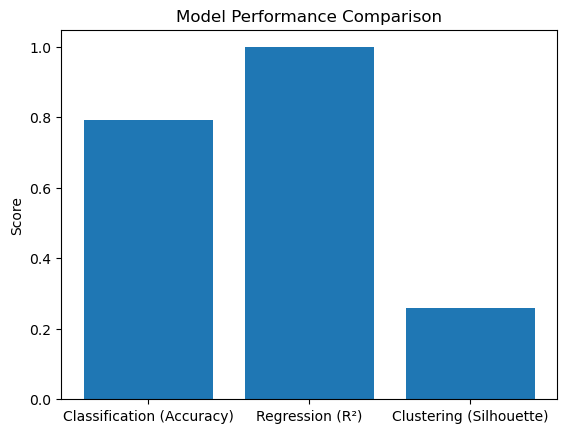

In [17]:
models = ['Classification (Accuracy)', 'Regression (R²)', 'Clustering (Silhouette)']
scores = [
    accuracy_score(y_test, y_pred_cls),
    r2_score(y_test_r, y_pred_reg),
    sil_score
]

plt.figure()
plt.bar(models, scores)
plt.ylabel("Score")
plt.title("Model Performance Comparison")
plt.show()


# CONCLUSION

This project successfully implemented an end-to-end telecom customer analytics
system using machine learning pipelines. Customer segmentation, churn prediction,
and revenue estimation were performed using appropriate models and evaluation
metrics, demonstrating a scalable and production-ready ML workflow.
